## Importing packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import folium

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model

#import testopentnsim

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")


In [2]:
info =pd.read_csv('info_volkerak_x0020.csv')
info.drop(columns={'Unnamed: 0'}, inplace=True)

ships = [[7, 8], [11, 13], [15], [19, 21], [24, 25], [29], [37, 38, 39]]

ships_nodes = pd.read_csv('NEW_ships_at_node.csv', index_col=0)

wlev = pd.read_csv('waterstanden.csv', delimiter=';', encoding='cp1252')
wlev = wlev[wlev['GROOTHEID_OMSCHRIJVING'] == 'Waterhoogte']
wlev = wlev[wlev['LOCATIE_CODE'] == 'RAKND']
wlev['timestamp'] = (pd.to_datetime(wlev['WAARNEMINGDATUM'], format='%d-%m-%Y', utc=True) + pd.to_timedelta(wlev['WAARNEMINGTIJD (MET/CET)']))
wlev.sort_values('timestamp', inplace=True)
wlev.reset_index(drop=True, inplace=True)

C:\Users\freek\AppData\Local\Temp\ipykernel_3988\3636094511.py:8: DtypeWarning:

Columns (46,47,49) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
%%capture --no-display
ship_nodes_1 = pd.DataFrame()
info_1 = pd.DataFrame()
t_start = []
sog_start = []
reduction = []
waterlevel = []
direction = []

enter = [0, 18]
r_f = [[0.65, 0.3], [0.65, 0.22]]

for i, case in enumerate(ships):
    for j, ind in enumerate(case):
        if any(info.index == ind):
            info_1 = info_1.append(info.loc[ind])
            oldind = info.loc[ind]['old index']
            ship_nodes_1 = ship_nodes_1.append(ships_nodes.loc[oldind])
            
            if ships_nodes.iloc[oldind, 0] < ships_nodes.iloc[oldind, 18]:
                d = 0
            else:
                d = 1
                
            direction.append(d)
            
            t_start.append(ships_nodes.iloc[oldind, enter[d]])
            sog_start.append(ships_nodes.iloc[oldind, enter[d] + 19])
            
            if j == 0:
                reduction.append(r_f[0])
            else:
                reduction.append(r_f[1])
                
            enter_time = pd.to_datetime(info.loc[ind]['enter time'], utc=True)
            waterlevel.append(wlev.loc[np.argmin(abs(wlev['timestamp'] - enter_time))]['NUMERIEKEWAARDE'] / 100)
    
    
    

In [4]:
waterlevel

[0.37, 0.37, 0.36, 0.34, 0.33, 0.31, 0.29, 0.29, 0.29, 0.26, 0.24, 0.25, 0.25]

## Creating network

In [5]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))

coords = [
          [
            4.431717395782471,
            51.699241285183355
          ],
          [
            4.428820610046387,
            51.69929448210502
          ],
          [
            4.425945281982422,
            51.69908169404305
          ],
          [
            4.423456192016602,
            51.69815073450679
          ],
          [
            4.4211602210998535,
            51.69706015754816
          ],
          [
            4.418971538543701,
            51.69584985235083
          ],
          [
              4.417018890380859,
              51.694626214192404
            ],
          [
            4.414615631103516,
            51.69348234860448
          ],
          [
            4.41126823425293,
            51.691540371057144
          ],
          [
            4.409422874450684,
            51.69052944565975
          ],
          [
            4.407556056976318,
            51.689545101867644
          ],
          [
            4.403843879699707,
            51.68756304739833
          ],
          [
            4.4016337394714355,
            51.686392397283925
          ],
          [
            4.399402141571045,
            51.68516850343353
          ],
          [
            4.397170543670654,
            51.68401109511487
          ],
          [
            4.395046234130859,
            51.68281374502816
          ],
          [
            4.392750263214111,
            51.68168288531602
          ],
          [
            4.390625953674316,
            51.680485473659196
          ],
          [
            4.388694763183594,
            51.6791815893984
          ]
        ]

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])
    
FG = nx.DiGraph()

map = folium.Map(location=[51.694, 4.415], zoom_start=14)
line = []
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
    
    folium.CircleMarker((node.geometry.y, node.geometry.x), popup=node.name, fill=True).add_to(map)
    line.append((node.geometry.y, node.geometry.x))
    
folium.PolyLine(line).add_to(map)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

#nx.draw(FG, positions,ax=ax)

map

## Simulation setup

In [6]:
# Start simpy environment (at a given date and time)
def set_simulation(FG, start):
    simulation_start = start
    sim = model.Simulation(simulation_start,FG)
    env = sim.environment
    env.FG = FG
    
    return sim, env

## Fleet

In [7]:
def add_vessel(sim, env, n, start_times, v_enter, speed_reduction, direction):

    Vessel = type('Vessel', 
              (core.Identifiable, core.HasLineUpArea, core.HasWaitingArea, core.HasSpeedReduction, core.HasLock, core.Movable, core.Routeable, core.VesselProperties, core.ExtraMetadata), {})

    start_point = 'Node 1' 
    end_point = 'Node 19'  
    
    def data_vessel(num, t0, v, sp):
        if (v > 0) == False:
            v = 4
            
        if num == 0:
            d_v = {"env": env,
                               "name": "Vessel",
                               "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                               "geometry": env.FG.nodes[start_point]['geometry'],
                               "v": v,
                               "lock_name": 'Volkeraksluizen_1',
                               "type": 'CEMT - Va',
                               "B": 11.40,
                               "H_e": 7.10,
                               "H_f": 5.40,
                               "T_e": 1.8,
                               "T_f": 3.5,
                               "L": 80.0,
                               "start_time": t0, "speed_reduction": sp, "operator_waiting": None}

        else:
            d_v = {"env": env,
                               "name": "Vessel",
                               "route": nx.dijkstra_path(FG, end_point, start_point, weight='length'),
                               "geometry": env.FG.nodes[end_point]['geometry'],
                               "v": v,
                               "lock_name": 'Volkeraksluizen_1',
                               "type": 'CEMT - Va',
                               "B": 11.40,
                               "H_e": 7.10,
                               "H_f": 5.40,
                               "T_e": 1.8,
                               "T_f": 3.5,
                               "L": 80.0,
                               "start_time": t0, "speed_reduction": sp, "operator_waiting": None}

        return d_v
    
    for i in range(n):
        t1 = start_times[i]
        
        v1 = v_enter[i]
        
        sp1 = speed_reduction[i]
        
        d1 = direction[i]
        
        vessel = Vessel(**data_vessel(d1, t1, v1, sp1))
        sim.add_vessels(start_point,end_point,[],vessel)
    
    return sim


## Infrastructure

In [21]:
def infrastructure(env, water_level, wlev_dif, simulation_start):
    waiting_area_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 5")

    lineup_area_1 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                              name = 'Volkeraksluizen_1', node = "Node 7", lineup_length = 200)

    lock_1 = core.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                             node_1 = "Node 9", node_2 = "Node 10", node_3 = "Node 11",
                             lock_length = 330, lock_width = 24, lock_depth = 4.5, 
                             doors_open = 2.5 * 60, doors_close = 1.6 * 60, wlev_dif = wlev_dif, disch_coeff = 0.75,
                             grav_acc = 9.81, opening_area = 8.0, opening_time = 2 * 60,
                             simulation_start = simulation_start, operating_time = 25*60)

    waiting_area_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                                name = "Volkeraksluizen_1", node = "Node 15")

    lineup_area_2 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                              name = "Volkeraksluizen_1", node = "Node 13", lineup_length = 200)
    
    speed_reduction_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 2")
    
    speed_reduction_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 18")
    
    
    lock_1.water_level = water_level
    env.FG.nodes["Node 10"]["Lock"] = [lock_1]

    env.FG.nodes["Node 5"]["Waiting area"] = [waiting_area_1]
    env.FG.nodes["Node 7"]["Line-up area"] = [lineup_area_1]

    env.FG.nodes["Node 15"]["Waiting area"] = [waiting_area_2]
    env.FG.nodes["Node 13"]["Line-up area"] = [lineup_area_2]
    
    env.FG.nodes["Node 2"]["Speed reduction"] = [speed_reduction_1]
    env.FG.nodes["Node 18"]["Speed reduction"] = [speed_reduction_2]
    
    
    return env

## Information from output

In [22]:
def waiting_times(vessels):
    
    waiting_to_waiting_area = []
    waiting_in_waiting_area = []
    waiting_in_lineup_area = []
    waiting_in_lock = []
    total_waiting_time = np.zeros(len(vessels))
    passage_time = np.zeros(len(vessels))

    for v in range(0,len(vessels)):
        for t in range(0,len(vessels[v].log["Message"])-1):
            if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
                waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
                waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
                waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
            if vessels[v].log["Message"][t] == "Passing lock stop":
                waiting_in_lock.append(vessels[v].log["Value"][t]/60)

    for v in range(len(vessels)):
        for t in range(0,len(vessels[v].log["Message"])-1):
            if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
                total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))
                
        passage_time[v] = (vessels[v].log['Timestamp'][-1] - vessels[v].log['Timestamp'][0]).seconds / 60
                
    return waiting_to_waiting_area, waiting_in_waiting_area, waiting_in_lineup_area, waiting_in_lock, total_waiting_time, passage_time


## Adding generator to simulation

In [23]:
#%%capture --no-display

def run_simulation(FG, start_time, v_enter, speed_reduction, n, direction, wlev_dif = 2, water_level="Node 11", duration=24*60*60):

    simulation_start = start_time[0]
    
    start_times = [0] #chronological -> direction [1, 2, 1, 2 ...]
    
    for t in start_time[1:]:
        start_times.append((t - start_time[0]).seconds)
        
    sim, env = set_simulation(FG, simulation_start)
    
    sim = add_vessel(sim, env, n, start_times, v_enter, speed_reduction, direction)

    env = infrastructure(env, water_level, wlev_dif, simulation_start)

    
    sim.run(duration = duration)
    
    return sim

## Run simulation

In [24]:
#start_times_ais = pd.read_csv('start_times.csv', usecols=[1,2])
start_times = pd.to_datetime(t_start)
v_start = sog_start
direction[0]

1

In [25]:
%%time
#%%capture --no-display

#start_times_ais = start_times_ais[:10]


n = len(reduction)

               
wlev_d = float(0.3)

sim = run_simulation(FG, start_times, v_start, reduction, n, direction, wlev_dif = wlev_d, water_level="Node 11")
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 

_, _, _, _, _, passage_time = waiting_times(vessels)


c:\users\freek\documents\1_tu delft - civiele techniek\msc hydraulic engineering\afstuderen\2_opentnsim\opentnsim\core.py:3385: ShapelyDeprecationWarning:

The proxy geometries (through the 'asShape()', 'asPoint()' or 'PointAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'Point()' constructor instead.

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
c:\users\freek\documents\1_

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-pack

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <functi

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0
160.0


    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <functi

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-pack

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

160.0


Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\proxy.py", line 44, in __setattr__
    object.__setattr__(self, name, value)
AttributeError: can't set attribute '_is_empty'
Exception ignored in: <function BaseGeometry.__del__ at 0x000001AB95EE0280>
Traceback (most recent call last):
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\shapely\geometry\base.py", line 199, in _empty
    self._is_empty = True
  File "C:\U

CPU times: total: 4.09 s
Wall time: 3.59 s


In [26]:
vessels = sim.environment.vessels
pd.DataFrame(vessels[0].log)

C:\Users\freek\anaconda3\envs\opentnsim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,Message,Timestamp,Value,Geometry
0,Sailing from node Node 19 to node Node 18 start,2019-08-06 03:31:02.000000,9.70000,POINT (4.388694763183594 51.6791815893984)
1,Sailing from node Node 19 to node Node 18 stop,2019-08-06 03:31:22.329928,9.70000,POINT (4.390625953674316 51.680485473659196)
2,Sailing from node Node 18 to node Node 17 start,2019-08-06 03:31:22.329928,6.30500,POINT (4.390625953674316 51.680485473659196)
3,Sailing from node Node 18 to node Node 17 stop,2019-08-06 03:31:53.786733,6.30500,POINT (4.392750263214111 51.68168288531602)
4,Sailing from node Node 17 to node Node 16 start,2019-08-06 03:31:53.786733,6.30500,POINT (4.392750263214111 51.68168288531602)
5,Sailing from node Node 17 to node Node 16 stop,2019-08-06 03:32:25.920173,6.30500,POINT (4.395046234130859 51.68281374502816)
6,Sailing from node Node 16 to node Node 15 start,2019-08-06 03:32:25.920173,6.30500,POINT (4.395046234130859 51.68281374502816)
7,Sailing from node Node 16 to node Node 15 stop,2019-08-06 03:32:57.375369,6.30500,POINT (4.397170543670654 51.68401109511487)
8,Sailing from node Node 15 to node Node 14 start,2019-08-06 03:32:57.375369,2.91000,POINT (4.397170543670654 51.68401109511487)
9,Sailing from node Node 15 to node Node 14 stop,2019-08-06 03:34:06.448995,2.91000,POINT (4.399402141571045 51.68516850343353)


## Time - Distance diagram

In [27]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig.x, orig.y, 
                         dest[0], dest[1])[2]
    
    return distance

In [28]:
def vessel_path(vessels):

    vessel_path_x = []
    vessel_path_t = []
    origin = 'Node 1'
    destination = 'Node 19'
    
    env = vessels[0].env
    
    v0 = pd.DataFrame.from_dict(vessels[0].log['Timestamp'])
    simulation_start = min(v0[0])
    
    vessel_path_x0 = env.FG.nodes['Node 1']['geometry']
    vessel_path_t0 = simulation_start.timestamp()
    
    for v in range(0,len(vessels)):
        vessel_path_xt = []
        vessel_path_tt = []
        vessel = pd.DataFrame.from_dict(vessels[v].log['Timestamp'])
        vessel_timestamp = vessel[0]
        
        for t in range(0,len(vessels[v].log["Message"])):  
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessel_timestamp[t].timestamp()-vessel_path_t0)
            
            
        vessel_path_x.append(vessel_path_xt)
        vessel_path_t.append(vessel_path_tt)
    return vessel_path_x, vessel_path_t

In [29]:
def draw_t_d(ax, vessels):
    
    FG = vessels[0].env.FG
    
    vessel_path_x0 = FG.nodes['Node 1']['geometry']
    
    # plot waiting, line up and lock areas
    nodes = ["Node 6", "Node 8", "Node 9", "Node 10", "Node 12", "Node 13", "Node 14", "Node 16"]
    nodes = FG.nodes
    x_ticks = []
    x_labels = []
    
    vessel_path_x, vessel_path_t = vessel_path(vessels)
    
    for v in range(0,len(vessels)):
        ax.plot(vessel_path_x[v],vessel_path_t[v])

    for node in nodes:
        x = calculate_distance(vessel_path_x0,(FG.nodes[node]['geometry'].x,FG.nodes[node]['geometry'].y))
        ax.axvline(x, color = 'k', linestyle = '--', linewidth = 1.0)
        x_ticks.append(x)
        
    x_chamber = [x_ticks[3], x_ticks[4]]
    
    for x in x_ticks:
        x_labels.append(round(min([abs(x - x_chamber[0]), abs(x - x_chamber[1])])))
        
    ylim = [-500, ax.get_ylim()[1] + 500]
    
    ax.set(xlabel="Distance to lock [m]", ylabel='Time [s]', xlim=[0,0.95*ax.get_xlim()[1]], ylim=ylim)#,xticks=x_ticks, xticklabels=x_labels)
    '''
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),1.1*ylim[0],'lock \n chamber',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y))-
             0.5*calculate_distance((FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y),(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),1.1*ylim[0],'line-up \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))+
             0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),1.1*ylim[0],'line-up \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)),1.1*ylim[0],'waiting \n area',horizontalalignment = 'center')
    ax.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),1.1*ylim[0],'waiting \n area',horizontalalignment = 'center')

    #ax.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
    #ax.xlabel("Distance [m]")
    #ax.xlim([0,0.95*ax.get_xlim()[1]])
    #ax.ylim([0,ax.get_ylim()[1]])
    #ax.ylabel("Time [s]")
    '''  

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')

    ax.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)),
              calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)), 
              calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))],
             [ylim[0], ylim[1], ylim[1], ylim[0]],'lightgrey')
      
    ax.invert_yaxis()
    
    
    return ax

In [30]:
def draw_t_d_ais(ax, ship_nodes_1, FG, t0):
    
    df = ship_nodes_1.reset_index(drop=True)
    
    t0 = t0
    
    for i, ship in df.iterrows():
        
        color = ax.get_lines()[i].get_color()
                
        d = []
        t = []
        
        p0 = FG.nodes['Node 1']['geometry']
        
        for j, node in enumerate(FG.nodes):
            p1 = FG.nodes[node]['geometry']
            _,_, dis = geod.inv(p0.x, p0.y, p1.x, p1.y)

            d.append(dis)

            t.append((pd.to_datetime(ship[j]) - t0).seconds)
        
        ax.plot(d, t, color=color, linestyle='--')
    
    return ax

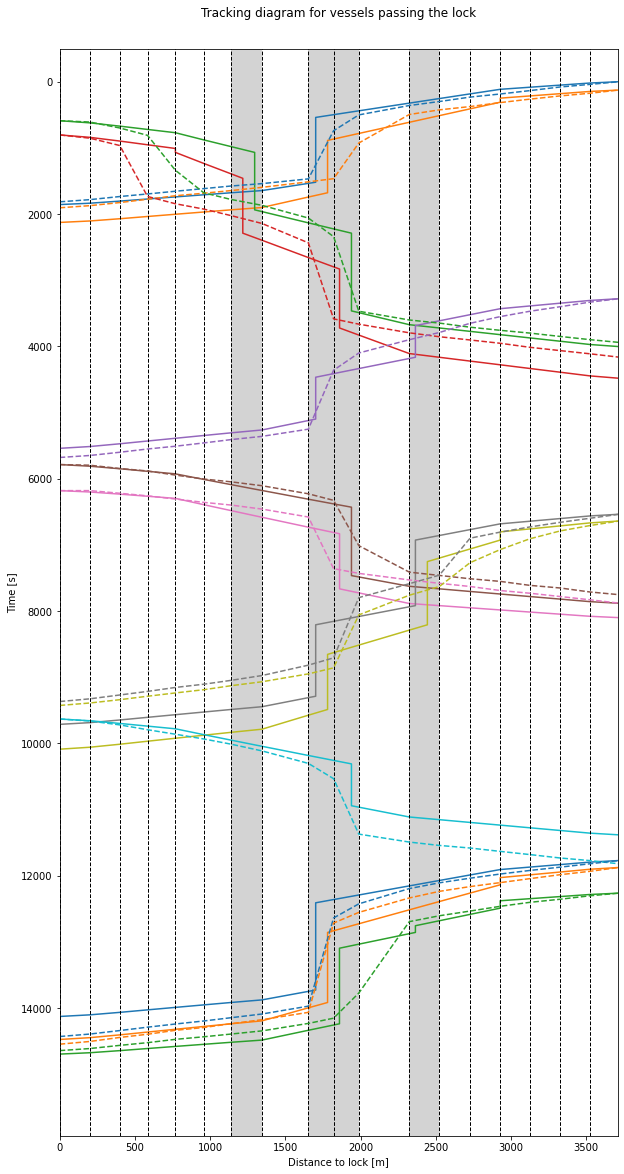

In [31]:
fig, ax = plt.subplots(figsize=(10, 20))
FG = vessels[0].env.FG
t0 = start_times[0]

ax = draw_t_d(ax, vessels)
ax = draw_t_d_ais(ax, ship_nodes_1, FG, t0)
plt.title("Tracking diagram for vessels passing the lock", pad=32);


## AIS Comparison

In [19]:
# Get passage time for two given nodes

def node_times(vessels, node_1, node_2):
    '''format node_1 and node_2 is [1, 21], with corresponding nodes for both directions.'''
    
    node_time = []
    
    for n, v in enumerate(vessels):
        log = pd.DataFrame(v.log)
        try:
            i = 0
            t1 = log[log['Message'] == f'Sailing from node Node {node_1[i]} to node Node {node_1[i] + 1} start']['Timestamp']
            t1 = t1.reset_index(drop=True)[0]

            t2 = log[log['Message'] == f'Sailing from node Node {node_2[i] - 1} to node Node {node_2[i]} stop']['Timestamp']
            t2 = t2.reset_index(drop=True)[0]
        
        except:
            try:
                i = 1
                t1 = log[log['Message'] == f'Sailing from node Node {node_1[i]} to node Node {node_1[i] - 1} start']['Timestamp']
                t1 = t1.reset_index(drop=True)[0]

                t2 = log[log['Message'] == f'Sailing from node Node {node_2[i] + 1} to node Node {node_2[i]} stop']['Timestamp']
                t2 = t2.reset_index(drop=True)[0]
                
            except:
                continue
        
        dt = (t2 - t1).seconds
        node_time.append(dt)
        
    return np.array(node_time)

def node_times_ais(ship_nodes_ais, node_1, node_2):
    '''format node_1 and node_2 is [1, 21], with corresponding nodes for both directions.'''
    
    node_time = []
    
    for _, s in ship_nodes_ais.iterrows():

        if s[node_1[0] - 1] < s[node_2[0] - 1]:
            t1 = s[node_1[0] - 1]
            t2 = s[node_2[0] - 1]
            
        else:
            t1 = s[node_1[1] - 1]
            t2 = s[node_2[1] - 1]
            
        dt = (pd.to_datetime(t2) - pd.to_datetime(t1)).seconds
        
        node_time.append(dt)
    
    return np.array(node_time)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

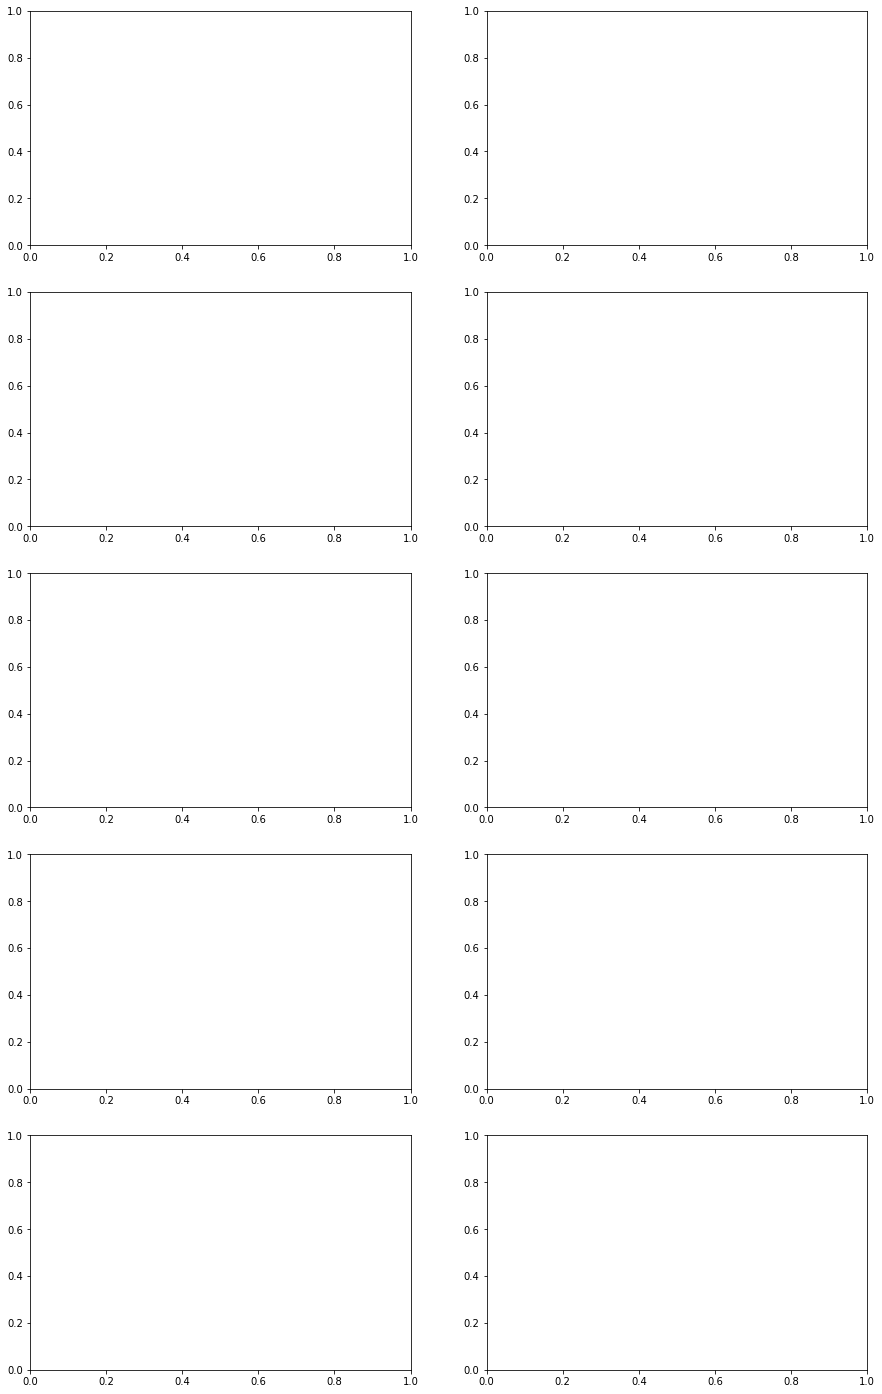

In [20]:
fig, axs = plt.subplots(5, 2, figsize=(15,25))

titles = ['Total passage time, 1 ship, 1st direction', 'Time in chamber: Node 10 - 12 / 12 - 10', 'Time in lock: Node 9 - 13 / 13 - 19',
         'Entering time: Node 5 - 10 / 17 - 12', 'Exiting time: Node 12 - 17 / 10 - 5']

limits = [[0, 80], [0, 50], [0, 80], [0, 40], [0, 20]]

node_1 = [[1, 21], [10, 12], [9, 13], [5, 17], [12, 10]]
node_2 = [[21, 1], [12, 10], [13, 9], [10, 12], [17, 5]]

vessels_plot = np.array(vessels)[:,0]
vessels_plot_ais = ship_nodes_1[0]

for i, ax in enumerate(axs[:,0]):
    
    node_times_plot = node_times(vessels_plot, node_1[i], node_2[i])
    node_times_ais_plot = node_times_ais(vessels_plot_ais, node_1[i], node_2[i])
    
    ax.hist([node_times_plot / 60, node_times_ais_plot / 60], bins=np.linspace(limits[i][0], limits[i][1], 50))
    ax.set(title=titles[i], xlabel='minutes', ylabel='ships');
    ax.legend([f'OpenTNSim, median = {round(np.median(node_times_plot / 60), 1)} minutes', f'AIS, median = {round(np.median(node_times_ais_plot / 60), 1)} minutes'])
    
titles = ['Total passage time, 1 ship, 2nd direction', 'Time in chamber: Node 10 - 12 / 12 - 10', 'Time in lock: Node 9 - 13 / 13 - 19',
         'Entering time: Node 5 - 10 / 17 - 12', 'Exiting time: Node 12 - 17 / 10 - 5']

limits = [[10, 60], [0, 30], [0, 40], [0, 25], [0, 15]]

node_1 = [[1, 21], [10, 12], [9, 13], [5, 17], [12, 10]]
node_2 = [[21, 1], [12, 10], [13, 9], [10, 12], [17, 5]]

vessels_plot = np.array(vessels)[:,1]
vessels_plot_ais = ship_nodes_1[1]

for i, ax in enumerate(axs[:,1]):
    
    node_times_plot = node_times(vessels_plot, node_1[i], node_2[i])
    node_times_ais_plot = node_times_ais(vessels_plot_ais, node_1[i], node_2[i])
    
    ax.hist([node_times_plot / 60, node_times_ais_plot / 60], bins=np.linspace(limits[i][0], limits[i][1], 50))
    ax.set(title=titles[i], xlabel='minutes', ylabel='ships');
    ax.legend([f'OpenTNSim, median = {round(np.median(node_times_plot / 60), 1)} minutes', f'AIS, median = {round(np.median(node_times_ais_plot / 60), 1)} minutes'])

In [ ]:
# Get node times with 1 node increments

node_numbers = np.arange(1, 22, 1)
node_numbers_reverse = np.arange(21, 0, -1)

# Node 11 is skipped because the location in the lock can be closer to node 10 or 12 for the AIS data.
node_numbers = node_numbers[node_numbers != 11]
node_numbers_reverse = node_numbers_reverse[node_numbers_reverse != 11]


vessels_plot = np.array(vessels)[:,0]
vessels_plot_ais = ship_nodes_1[0]

node_times_plot = []
node_times_plot_ais = []

x_labels = []

for i in range(len(node_numbers) - 1):
    node_1 = [node_numbers[i], node_numbers_reverse[i]]
    node_2 = [node_numbers[i + 1], node_numbers_reverse[i + 1]]
    
    node_times_plot.append(np.median(node_times(vessels_plot, node_1, node_2)))
    node_times_plot_ais.append(np.median(node_times_ais(vessels_plot_ais, node_1, node_2)))

    x_label = f'Node {node_numbers[i]} - Node {node_numbers[i + 1]}'
    x_labels.append(x_label)

fig, axs = plt.subplots(3, 1, figsize=(15, 15))
x_ticks = np.arange(1, 20, 1)

node_times_plot = np.array(node_times_plot)
node_times_plot_ais = np.array(node_times_plot_ais)

ax = axs[0]
ax.bar(x_ticks, node_times_plot_ais)
ax.bar(x_ticks, node_times_plot, alpha=.8)

ax.set(xticks=x_ticks, xticklabels=[], title='Average passage time between nodes', ylabel='seconds');
ax.legend(['AIS', 'OpenTNSim'])
ax.grid(True, axis='x')

ax = axs[1]
ax.bar(x_ticks, node_times_plot_ais - node_times_plot)
ax.axhline(0, color='k')

ax.set(xticks=x_ticks, xticklabels=[], title='Difference in average passage time between nodes, AIS - OpenTNSim', ylabel='seconds');
ax.grid(True, axis='x')

ax = axs[2]
ax.bar(x_ticks, node_times_plot_ais / node_times_plot - 1, bottom = 1)
ax.axhline(1, color='k')

ax.set(xticks=x_ticks, xticklabels=x_labels, title='Relative difference in average passage time between nodes, AIS / OpenTNSim', ylabel='AIS / OpenTNSim')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");
ax.grid(True, axis='x')